## Predict Daily Minimum Temperatures

Loaded dataset: 3650 rows, columns = ['Date', 'Temp']
        Date  Temp
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8
Splits -> train: 2556, val: 547, test: 547
FFN shapes: (2526, 30) (547, 30) (547, 30)
RNN shapes: (2526, 30, 1) (547, 30, 1) (547, 30, 1)
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 19.

=== RESULTS (scaled units) ===
Naive baseline   : MAE=0.4983, RMSE=0.6296
FFN (FeedForward): MAE=0.4436, RMSE=0.5659, Train time=3.63s
GRU (RNN)        : MAE=0.4255, RMSE=0.5440, Train time=30.16s

=== RESULTS (°C) ===
Naive baseline   : MAE=2.037 °C, RMSE=2.574 °C
FFN (FeedForward): MAE=1.814 °C, RMSE=2.314 °C, Train time=3.63s
GRU (RNN)        : MAE=1.740 °C, RMSE=2.224 °C, Train time=30.16s

Saved plots: learning_curves.png, test_predictions.png

--- Reflection ---
In this experiment, GRU achieved the lower test RMS

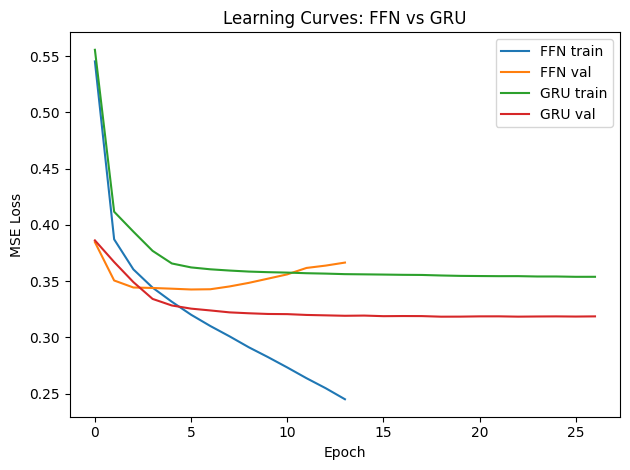

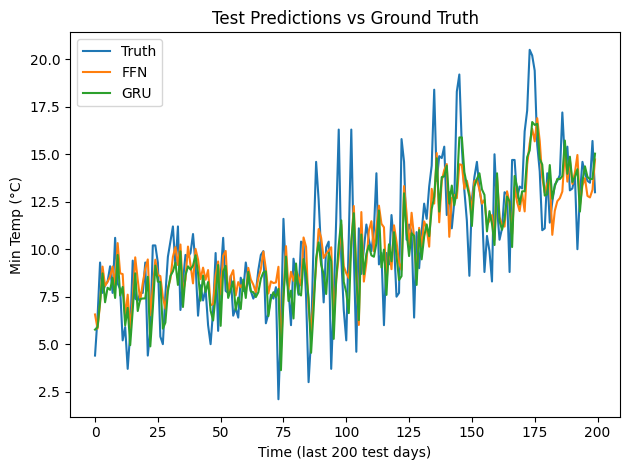

In [1]:
# rnn_vs_ffn_melbourne_temps.py
# Predict next day's minimum temperature from past daily temps.
# Compares Feed-Forward NN vs. GRU (RNN) on the same task.

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen
import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Config
# -----------------------------
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
WINDOW = 30          # number of past days to use
VAL_RATIO = 0.15     # of the whole series (after train split)
TEST_RATIO = 0.15
BATCH_SIZE = 64
EPOCHS = 80
PATIENCE = 8
LR = 1e-3
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Load dataset
# -----------------------------
raw = urlopen(URL).read()
df = pd.read_csv(io.BytesIO(raw))
# Ensure correct types and order
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
series = df["Temp"].values.astype("float32")  # shape (3650,)

print(f"Loaded dataset: {df.shape[0]} rows, columns = {list(df.columns)}")
print(df.head())

# -----------------------------
# Train/Val/Test split (time-order)
# -----------------------------
n = len(series)
n_test = int(n * TEST_RATIO)
n_val = int(n * VAL_RATIO)
n_train = n - n_val - n_test

train = series[:n_train]
val   = series[n_train:n_train+n_val]
test  = series[n_train+n_val:]

print(f"Splits -> train: {len(train)}, val: {len(val)}, test: {len(test)}")

# -----------------------------
# Scaling (fit on train only)
# -----------------------------
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1)).ravel()
val_scaled   = scaler.transform(val.reshape(-1, 1)).ravel()
test_scaled  = scaler.transform(test.reshape(-1, 1)).ravel()

# -----------------------------
# Windowing utility
# -----------------------------
def make_windows(arr, window):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
    X = np.array(X)
    y = np.array(y)
    return X, y

# Build windows per split
Xtr, ytr = make_windows(train_scaled, WINDOW)
Xv,  yv  = make_windows(np.concatenate([train_scaled[-WINDOW:], val_scaled]), WINDOW)
# Note: The val windows start right after the last train point to preserve continuity.

# For test, start windows at the boundary between (train+val) and test
concat_for_test = np.concatenate([np.concatenate([train_scaled, val_scaled])[-WINDOW:], test_scaled])
Xt, yt = make_windows(concat_for_test, WINDOW)

# Shapes for FFN (flatten) vs RNN (keep time axis)
Xtr_ffn = Xtr.copy()           # (N, WINDOW)
Xv_ffn  = Xv.copy()
Xt_ffn  = Xt.copy()

Xtr_rnn = Xtr[..., np.newaxis] # (N, WINDOW, 1)
Xv_rnn  = Xv[..., np.newaxis]
Xt_rnn  = Xt[..., np.newaxis]

print("FFN shapes:", Xtr_ffn.shape, Xv_ffn.shape, Xt_ffn.shape)
print("RNN shapes:", Xtr_rnn.shape, Xv_rnn.shape, Xt_rnn.shape)

# -----------------------------
# Baseline: Naive (predict yesterday)
# -----------------------------
def naive_baseline_mae_rmse(test_scaled, window):
    preds = test_scaled[:-1]  # predict t by value at t-1
    truth = test_scaled[1:]
    mae = np.mean(np.abs(preds - truth))
    rmse = np.sqrt(np.mean((preds - truth) ** 2))
    return mae, rmse

naive_mae, naive_rmse = naive_baseline_mae_rmse(test_scaled, WINDOW)

# -----------------------------
# Models
# -----------------------------
def build_ffn(window):
    model = keras.Sequential([
        layers.Input(shape=(window,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="linear")
    ])
    model.compile(optimizer=keras.optimizers.Adam(LR), loss="mse", metrics=["mae"])
    return model

def build_gru(window):
    model = keras.Sequential([
        layers.Input(shape=(window, 1)),
        layers.GRU(64, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")
    ])
    model.compile(optimizer=keras.optimizers.Adam(LR), loss="mse", metrics=["mae"])
    return model

es = keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=PATIENCE, restore_best_weights=True, verbose=1
)

# -----------------------------
# Train FFN
# -----------------------------
ffn = build_ffn(WINDOW)
t0 = time.perf_counter()
hist_ffn = ffn.fit(
    Xtr_ffn, ytr,
    validation_data=(Xv_ffn, yv),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[es]
)
t1 = time.perf_counter()
ffn_time = t1 - t0

# Evaluate FFN
ffn_pred_scaled = ffn.predict(Xt_ffn, verbose=0).ravel()
ffn_mae = np.mean(np.abs(ffn_pred_scaled - yt))
ffn_rmse = np.sqrt(np.mean((ffn_pred_scaled - yt) ** 2))

# -----------------------------
# Train GRU (RNN)
# -----------------------------
gru = build_gru(WINDOW)
t0 = time.perf_counter()
hist_gru = gru.fit(
    Xtr_rnn, ytr,
    validation_data=(Xv_rnn, yv),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[es]
)
t1 = time.perf_counter()
gru_time = t1 - t0

# Evaluate GRU
gru_pred_scaled = gru.predict(Xt_rnn, verbose=0).ravel()
gru_mae = np.mean(np.abs(gru_pred_scaled - yt))
gru_rmse = np.sqrt(np.mean((gru_pred_scaled - yt) ** 2))

# -----------------------------
# Inverse-scale predictions for human-readable °C
# -----------------------------
def inverse_scale(arr_scaled):
    return scaler.inverse_transform(arr_scaled.reshape(-1,1)).ravel()

yt_c   = inverse_scale(yt)
ffn_c  = inverse_scale(ffn_pred_scaled)
gru_c  = inverse_scale(gru_pred_scaled)

ffn_mae_c  = np.mean(np.abs(ffn_c - yt_c))
ffn_rmse_c = np.sqrt(np.mean((ffn_c - yt_c) ** 2))
gru_mae_c  = np.mean(np.abs(gru_c - yt_c))
gru_rmse_c = np.sqrt(np.mean((gru_c - yt_c) ** 2))
naive_mae_c  = np.mean(np.abs(inverse_scale(test_scaled[:-1]) - inverse_scale(test_scaled[1:])))
naive_rmse_c = np.sqrt(np.mean((inverse_scale(test_scaled[:-1]) - inverse_scale(test_scaled[1:]))**2))

# -----------------------------
# Report
# -----------------------------
print("\n=== RESULTS (scaled units) ===")
print(f"Naive baseline   : MAE={naive_mae:.4f}, RMSE={naive_rmse:.4f}")
print(f"FFN (FeedForward): MAE={ffn_mae:.4f}, RMSE={ffn_rmse:.4f}, Train time={ffn_time:.2f}s")
print(f"GRU (RNN)        : MAE={gru_mae:.4f}, RMSE={gru_rmse:.4f}, Train time={gru_time:.2f}s")

print("\n=== RESULTS (°C) ===")
print(f"Naive baseline   : MAE={naive_mae_c:.3f} °C, RMSE={naive_rmse_c:.3f} °C")
print(f"FFN (FeedForward): MAE={ffn_mae_c:.3f} °C, RMSE={ffn_rmse_c:.3f} °C, Train time={ffn_time:.2f}s")
print(f"GRU (RNN)        : MAE={gru_mae_c:.3f} °C, RMSE={gru_rmse_c:.3f} °C, Train time={gru_time:.2f}s")

# -----------------------------
# Plots
# -----------------------------
# 1) Learning curves
plt.figure()
plt.plot(hist_ffn.history["loss"], label="FFN train")
plt.plot(hist_ffn.history["val_loss"], label="FFN val")
plt.plot(hist_gru.history["loss"], label="GRU train")
plt.plot(hist_gru.history["val_loss"], label="GRU val")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.title("Learning Curves: FFN vs GRU")
plt.legend()
plt.tight_layout()
plt.savefig("learning_curves.png", dpi=160)

# 2) Predictions vs truth (last 200 test points for clarity)
k = min(200, len(yt_c))
plt.figure()
plt.plot(range(k), yt_c[-k:], label="Truth")
plt.plot(range(k), ffn_c[-k:], label="FFN")
plt.plot(range(k), gru_c[-k:], label="GRU")
plt.xlabel("Time (last 200 test days)")
plt.ylabel("Min Temp (°C)")
plt.title("Test Predictions vs Ground Truth")
plt.legend()
plt.tight_layout()
plt.savefig("test_predictions.png", dpi=160)

print("\nSaved plots: learning_curves.png, test_predictions.png")

# -----------------------------
# Reflection (prints a short takeaway)
# -----------------------------
ffn_better = ffn_rmse_c < gru_rmse_c
winner = "FFN" if ffn_better else "GRU"
why = ("FFN trained faster but lacked temporal memory"
       if not ffn_better else
       "Simple temporal structure may be captured by recent lags alone")

print("\n--- Reflection ---")
print(f"In this experiment, {winner} achieved the lower test RMSE in °C.")
print("FFN uses flattened lags; GRU learns temporal dynamics directly.")
print("RNNs often generalize better on sequential patterns, while FFNs train faster with fewer sequential inductive biases.")
